# mlops-zoomcamp HW1 - https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/01-intro/homework.md

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## 2. Load Data

In [2]:
def get_data_from_local(data_path, data_purpose:str):
    data = pd.read_parquet(data_path, engine='pyarrow')
    print("{} data shape: ".format(data_purpose), data.shape)
    print("{} data records count: ".format(data_purpose),data.shape[0])
    return data 

## 3. Preprocessing Step

In [3]:
def create_duration_feature(data, data_month:str):
    data['duration'] = (data['dropOff_datetime'] - data['pickup_datetime']).dt.total_seconds()/60
    print("Average trip duration in {}: ".format(data_month), data['duration'].mean().round(3))
    return data

In [4]:
def preprocess_data(data, data_purpose:str):
    clean_data = data.loc[(data["duration"]>=1) & (data["duration"]<=60)].reset_index(drop=True)
    
    print("Number of values other than 1 to 60 minutes(Dropped value count): ", data.shape[0] - clean_data.shape[0])
    
    ml_data = clean_data[["PUlocationID", "DOlocationID", "duration"]]
    
    ml_data['PUlocationID'] = ml_data['PUlocationID'].fillna(-1)
    ml_data['DOlocationID'] = ml_data['DOlocationID'].fillna(-1)
    
    all_data_len = len(ml_data)
    minus_one_data_len = len(ml_data.loc[ml_data["PUlocationID"] == -1])
    percentage_missing_value = ((minus_one_data_len / all_data_len) *100)
    print("\nFractions of NANs for the PU location ID in {} data: ".format(data_purpose), percentage_missing_value)
    
    categorical = ['PUlocationID', 'DOlocationID']
    
    ml_data[categorical] = ml_data[categorical].astype(str)
    dicts = ml_data[categorical].to_dict(orient='records')
    
    return ml_data, dicts

## 4. Training and Validation Step

In [5]:
def training_step(data, dicts):
    
    dv = DictVectorizer()
    lr = LinearRegression()
    
    target = 'duration'
    
    X_train = dv.fit_transform(dicts)
    print("\nDimensionality of train matrix: ", X_train.shape[1])
    y_train = data[target].values

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    print('\nTrain RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred)))
    
    return dv, lr

def validation_step(data, dicts, dv, lr):
    
    target = 'duration'
    
    X_val = dv.transform(dicts)
    y_val = data[target].values
    
    y_val_pred = lr.predict(X_val)
    print('\nValidation RMSE: ', np.sqrt(mean_squared_error(y_val, y_val_pred)))

## 5. Process of Training Data

In [6]:
train_data_path = 'data/fhv_tripdata_2021-01.parquet'
january_data = get_data_from_local(train_data_path, "Train")

january_data = create_duration_feature(january_data, "January")

Train data shape:  (1154112, 7)
Train data records count:  1154112
Average trip duration in January:  19.167


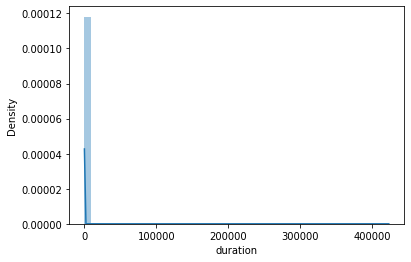

In [7]:
sns.distplot(january_data['duration']);

In [8]:
ml_data_for_train, train_dicts = preprocess_data(january_data, "Train")

dictvec, linreg = training_step(ml_data_for_train, train_dicts)

Number of values other than 1 to 60 minutes(Dropped value count):  44286

Fractions of NANs for the PU location ID in Train data:  83.52732770722618

Dimensionality of train matrix:  525

Train RMSE:  10.5285194284187


## 6. Process of Validation Data

In [9]:
val_data_path = 'data/fhv_tripdata_2021-02.parquet'
february_data = get_data_from_local(val_data_path, "Validation")

february_data = create_duration_feature(february_data, "February")

Validation data shape:  (1037692, 7)
Validation data records count:  1037692
Average trip duration in February:  20.707


In [10]:
ml_data_for_val, val_dicts = preprocess_data(february_data, "Validation")

validation_step(ml_data_for_val, val_dicts, dictvec, linreg)

Number of values other than 1 to 60 minutes(Dropped value count):  47579

Fractions of NANs for the PU location ID in Validation data:  85.71354986754038

Validation RMSE:  11.014285518755779
